In [1]:
from Embedders import get_embedder
from database.database import Database, get_db_params
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
examples = pd.read_json('data/dataset/small/nontrivial.jsonl', lines=True)

embedder = get_embedder(
    model_name='BAAI/bge-small-en',
    device='mps',
    normalize=True
)

db = Database(get_db_params())
db.test_connection()

=================================CONFIG=================================
Database         User             Host                             Port            
citeline_db      bbasseri         localhost                        5432            
Database version: ('PostgreSQL 17.3 (Homebrew) on x86_64-apple-darwin23.6.0, compiled by Apple clang version 16.0.0 (clang-1600.0.26.6), 64-bit',)


In [73]:
from dataclasses import asdict

def get_all_query_results(example):
    sentence = example.sent_no_cit
    embedding = embedder([sentence])[0]
    query_results = db.query_vector_table(
        table_name='bge',
        query_vector=embedding,
        metric='vector_cosine_ops',
        top_k=2453320,
        use_index=False)
    
    df = pd.DataFrame([asdict(result) for result in query_results])
    # Transform the distance column to numpy arrays
    df['distance'] = df['distance'].apply(lambda x: np.array(x))
    return df
    # return np.array([result.distance for result in query_results])
    

all_results = [get_all_query_results(examples.iloc[i]) for i in range(len(examples))]
print(all_results[0].head())

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

   chunk_id                               doi  \
0   1903631  10.1046/j.1365-8711.2002.05601.x   
1   2189513                    10.1086/430292   
2   1764149       10.1103/PhysRevD.108.123518   
3   2189495                    10.1086/430292   
4     76247  10.1046/j.1365-8711.2003.06254.x   

                                                text  distance  
0  The ‘true’ cosmology should be the cosmology t...  0.074071  
1  However, independent of these assumptions, the...  0.074598  
2  We find, after unblinding, that our best-fit c...  0.075399  
3  Recalling equation (5) , by choosing the norma...  0.077706  
4  2002). The solid curves in Fig. 4 show the res...  0.079689  


In [74]:
# Save each dataframe as a parquet file
for i, df in enumerate(all_results):
    df.to_parquet(f'temp_analysis_results_{i}.parquet')

# # Load later
# import glob
# loaded_results = []
# for file in sorted(glob.glob('results_*.parquet')):
#     loaded_results.append(pd.read_parquet(file))

In [ ]:
# Get the distance column from each dataframe, cast to numpy array


all_distances = [df['distance'].to_numpy() for df in all_results]
print(all_distances[0])

[0.07407133 0.07459786 0.07539867 ... 0.30499459 0.30686004 0.34359813]


: 

In [ ]:
def find_spike(distances):
    num_bins = 700
    counts, bin_edges = np.histogram(distances, bins=num_bins)

    spike_count_indices = [i for i in range(1, len(counts) - 1)
                           if counts[i] > 2*counts[i - 1]
                           and counts[i] > 2*counts[i + 1]
                           and counts[i] > 10_000]
    bin_edges = [(bin_edges[i], bin_edges[i+1]) for i in spike_count_indices]
    return {'spike_indexes': spike_count_indices, 'bin_edges': bin_edges}


spike_data = [find_spike(distances) for distances in all_results[0]['distance']]
for i, data in enumerate(spike_data):
    print(f"{i}: {data}")

In [8]:
full_distances = np.array([get_all_distances(example) for _, example in examples.iterrows()])
np.save('data/dataset/small/nontrivial_distances.npy', full_distances)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

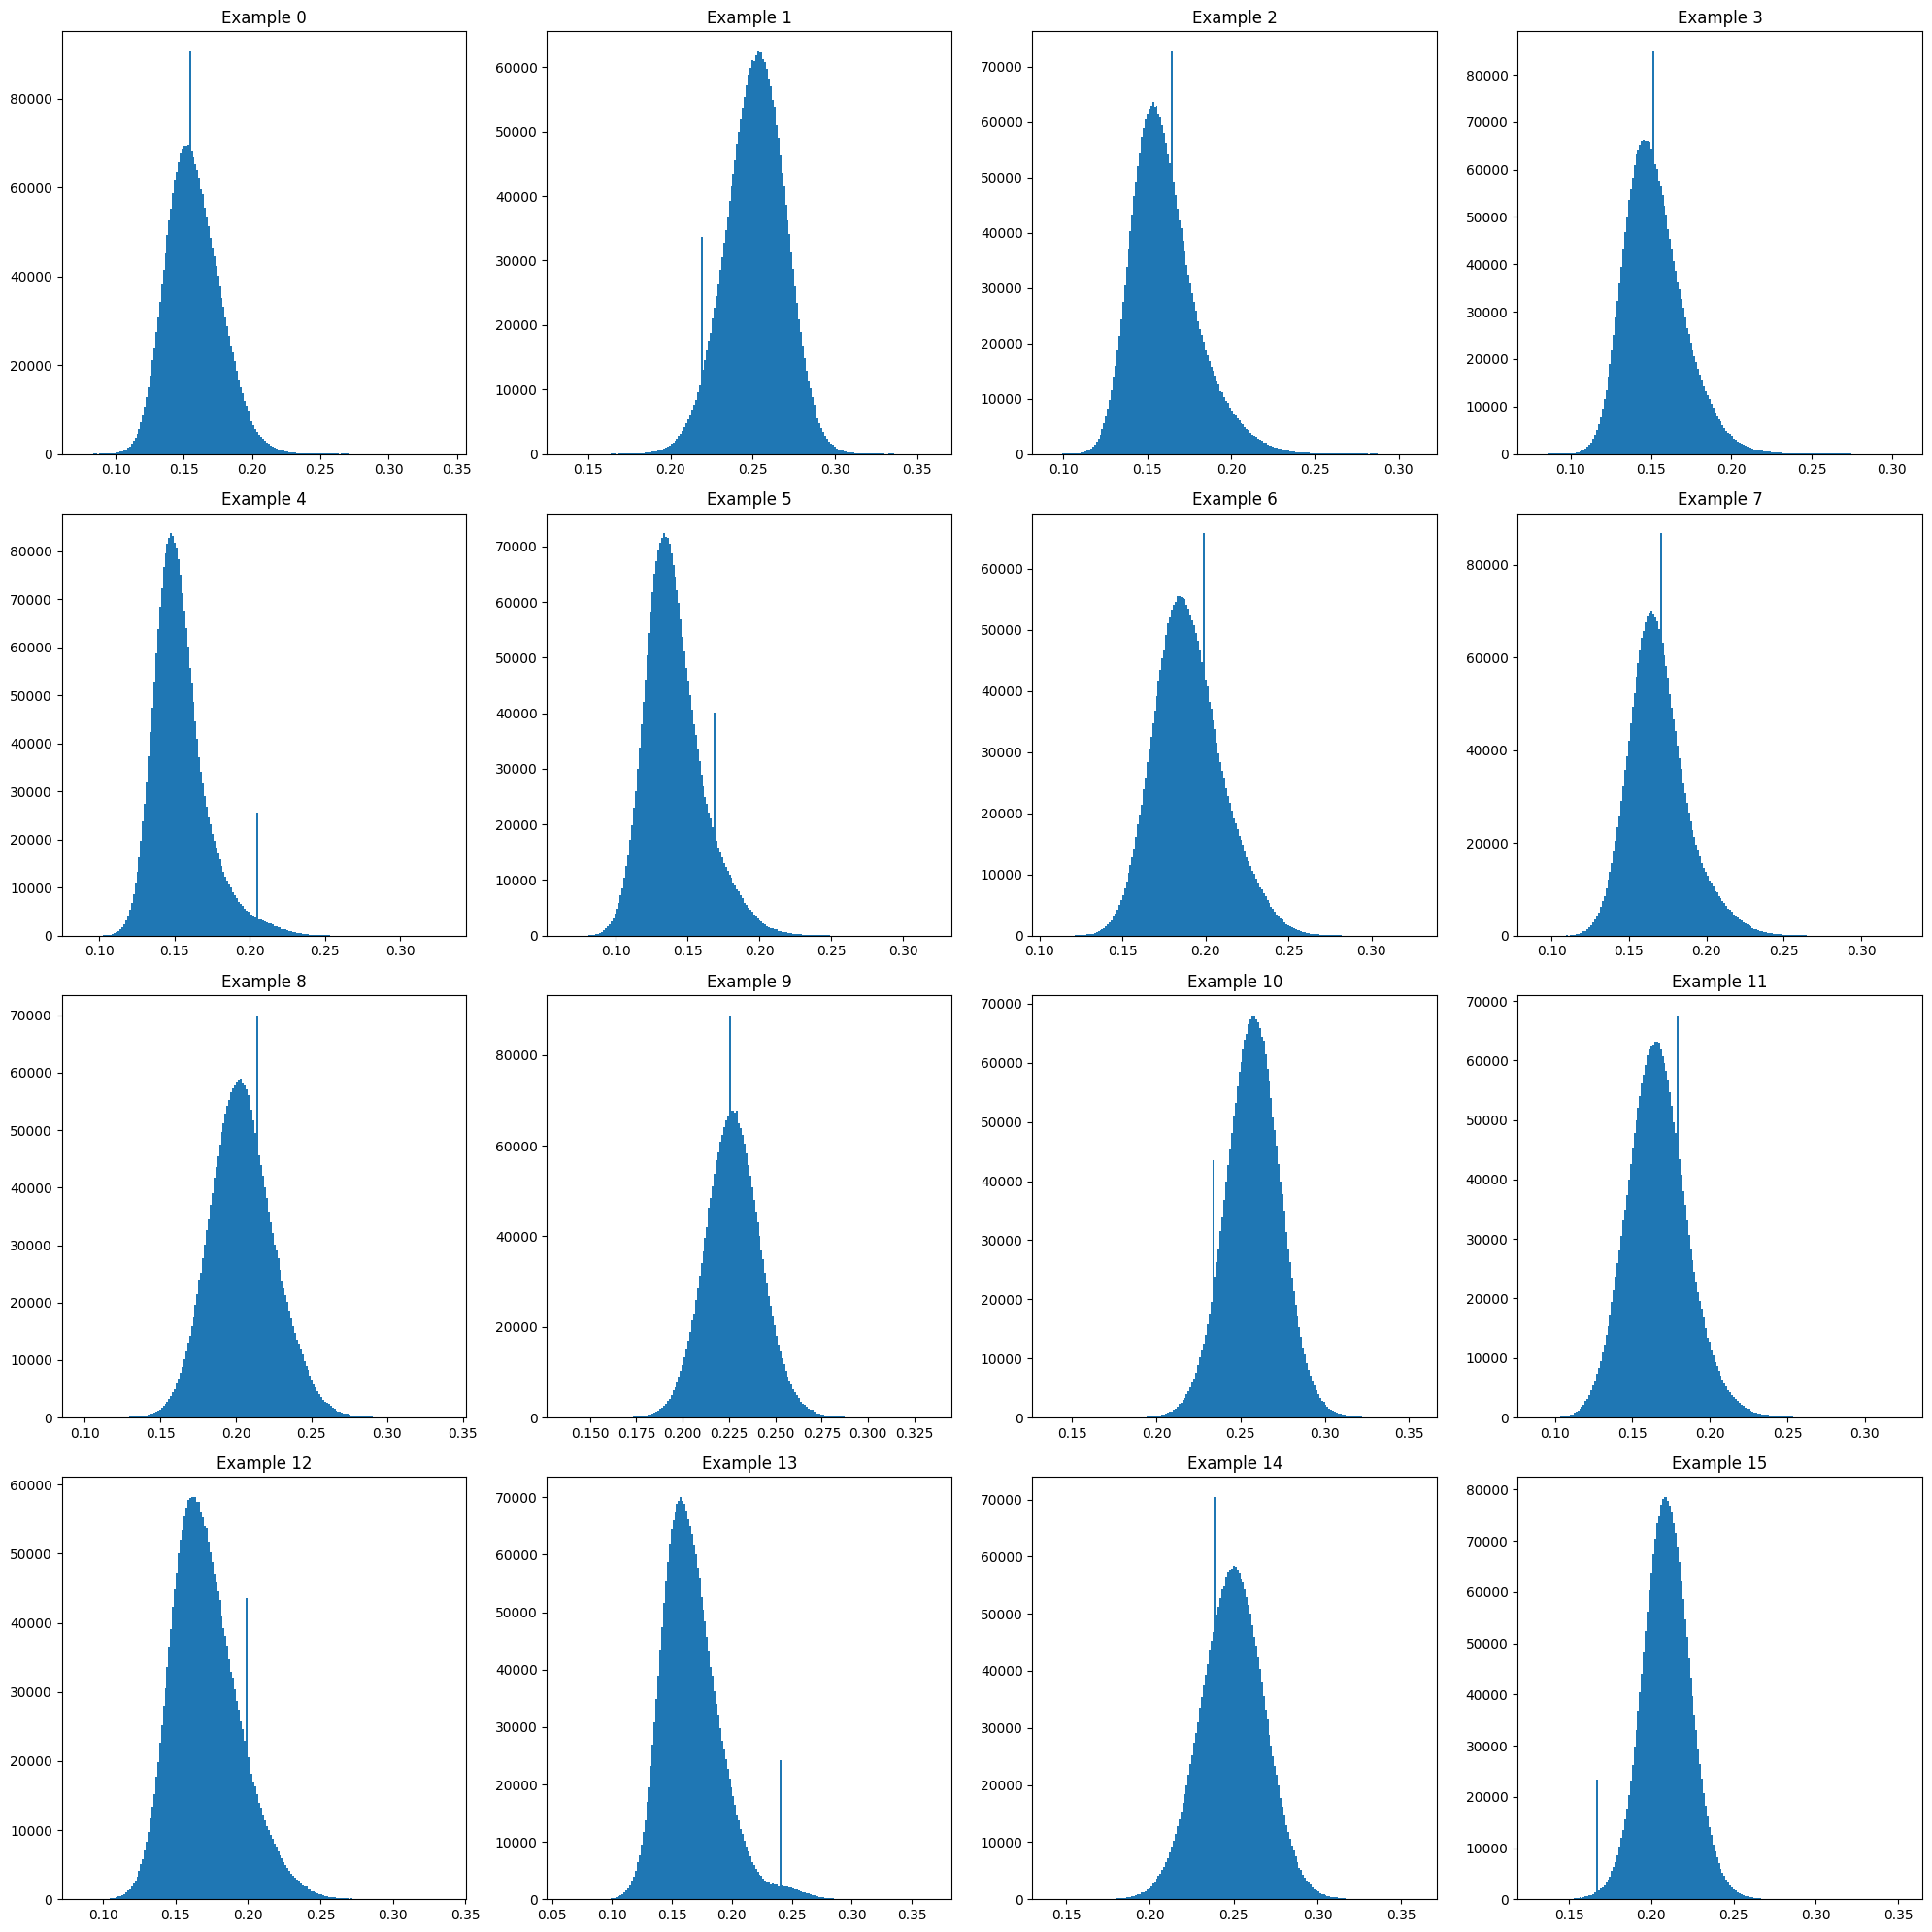

In [49]:
# create a 4 x 4 grid of histograms
fig, axs = plt.subplots(4, 4, figsize=(20, 20))
num_bins = int(0.125 * np.sqrt(len(full_distances[0])) + 1)
for i, ax in enumerate(axs.flat):
    ax.hist(full_distances[i], bins=num_bins)
    ax.set_title(f'Example {i}')
plt.tight_layout()
plt.show()

In [13]:
# Write a table of summary statistics
summary = pd.DataFrame(
    data=[np.mean(full_distances, axis=1), np.std(full_distances, axis=1)],
    index=['Mean', 'Standard Deviation']
).transpose()
print(summary)

        Mean  Standard Deviation
0   0.157358            0.019465
1   0.251396            0.018093
2   0.160601            0.019594
3   0.152421            0.018475
4   0.154452            0.018855
5   0.141275            0.020671
6   0.190105            0.020881
7   0.169142            0.019232
8   0.204500            0.021277
9   0.227336            0.014901
10  0.257326            0.016481
11  0.166432            0.019543
12  0.171358            0.023203
13  0.167265            0.025660
14  0.249083            0.018860
15  0.208873            0.015164


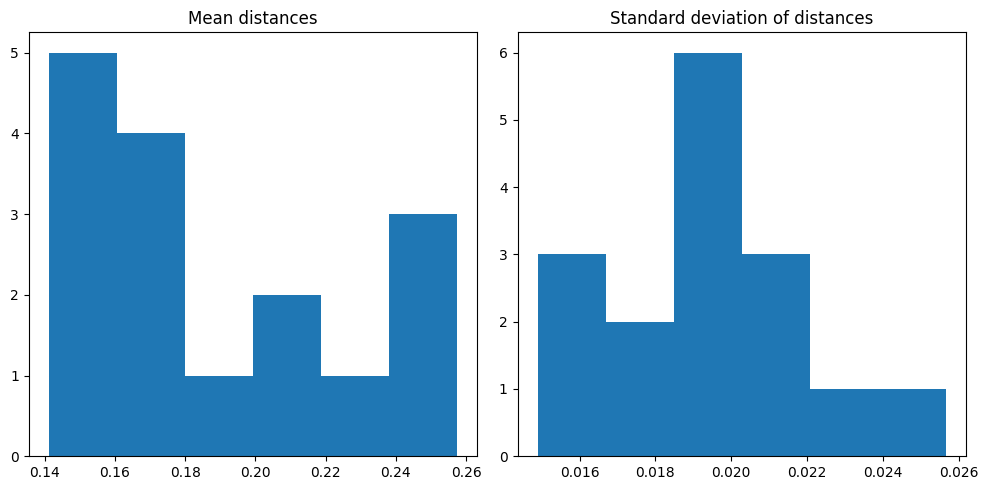

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Mean histogram
axs[0].set_title('Mean distances')
axs[0].hist(summary.Mean, bins=6)

# Standard deviation histogram
axs[1].set_title('Standard deviation of distances')
axs[1].hist(summary['Standard Deviation'], bins=6)

plt.tight_layout()
plt.show()


In [23]:
from collections import Counter


def count_in_intervals(values, interval_width=0.005):
    # Function to determine which bin a value belongs to
    def get_bin(x):
        # Floor to nearest interval (handling floating point precision)
        return np.floor(x / interval_width) * interval_width

    # Get the bin for each value and count with Counter
    bins = [get_bin(x) for x in values]
    counts = Counter(bins)

    # Sort by bin value for easier interpretation
    sorted_counts = {k: counts[k] for k in sorted(counts.keys())}

    return sorted_counts

interval_counts = [count_in_intervals(distances) for distances in full_distances]

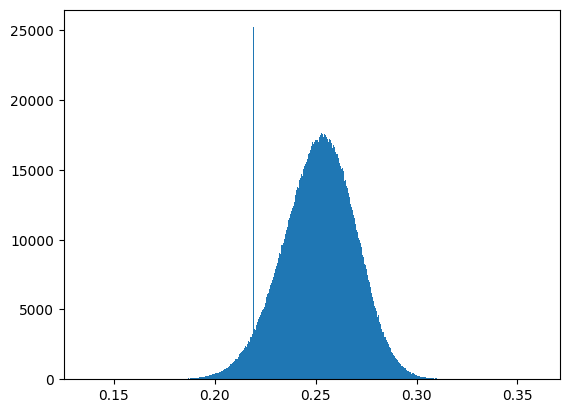

In [25]:
plt.hist(full_distances[1], bins=700)
plt.show()

In [37]:
x = 0.001
center = 0.225
len([d for d in full_distances[1] if center - x < d < center + x])

34432

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Found 685 spike(s) in the histogram:
Bin 445: Range [0.1997, 0.1999] contains 209 values
Sample distances: [0.19971616270685388, 0.1997162103229787, 0.19971640112541167]
Bin 449: Range [0.2003, 0.2004] contains 203 values
Sample distances: [0.2002851963467901, 0.20028791437050553, 0.2002880454320518]
Bin 450: Range [0.2004, 0.2006] contains 196 values
Sample distances: [0.200428640982954, 0.20042951103174755, 0.20042955881794777]
Bin 452: Range [0.2007, 0.2009] contains 224 values
Sample distances: [0.20071352713870927, 0.20071575675761877, 0.20071607849480488]
Bin 453: Range [0.2009, 0.2010] contains 208 values
Sample distances: [0.20085614932417217, 0.2008585336382731, 0.20086011889154032]
Bin 454: Range [0.2010, 0.2011] contains 201 values
Sample distances: [0.20099902167898842, 0.2009991053935133, 0.20100083377978817]
Bin 455: Range [0.2011, 0.2013] contains 205 values
Sample distances: [0.20114223967269895, 0.2011448859143824, 0.20114488642628758]
Bin 456: Range [0.2013, 0.2014] c

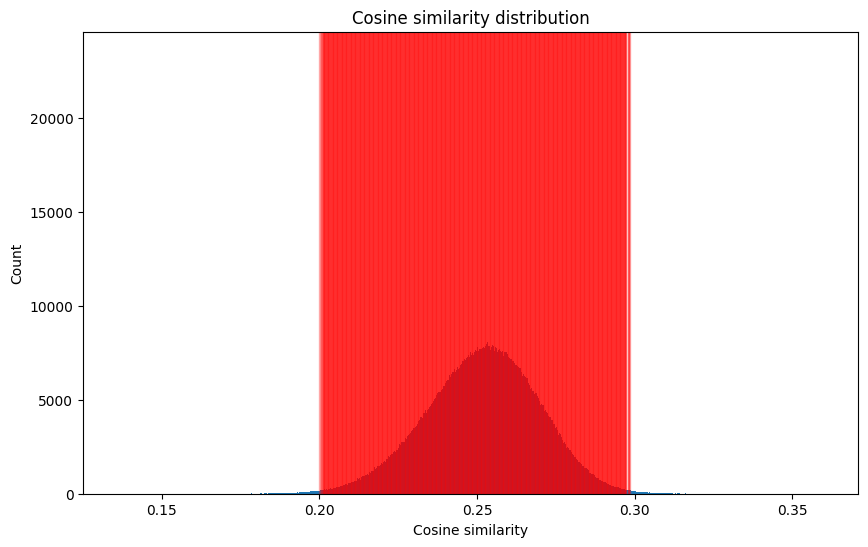

In [38]:
# def analyze_example(example):
#     sentence = example.sent_no_cit
#     target_dois = example.citation_dois

#     embedding = embedder([sentence])[0]
#     query_results = db.query_vector_table(
#         table_name='bge',
#         query_vector=embedding,
#         metric='vector_cosine_ops',
#         top_k=2453320,
#         use_index=False)

#     all_distances = np.array([result.distance for result in query_results])

#     # Get histogram data explicitly
#     num_bins = int(np.sqrt(len(all_distances)))
#     counts, bin_edges = np.histogram(all_distances, bins=num_bins)

#     # Find the significant spikes (bins with counts > 3x median)
#     median_count = np.median(counts)
#     spike_indices = np.where(counts > 3 * median_count)[0]

#     # Print information about the spikes
#     print(f"Found {len(spike_indices)} spike(s) in the histogram:")
#     for i in spike_indices:
#         bin_start = bin_edges[i]
#         bin_end = bin_edges[i+1]
#         print(
#             f"Bin {i}: Range [{bin_start:.4f}, {bin_end:.4f}] contains {counts[i]} values")

#         # Find some examples from this bin
#         bin_samples = [r for r in query_results
#                        if bin_start <= r.distance < bin_end][:3]
#         print(f"Sample distances: {[r.distance for r in bin_samples]}")

#     # Plot with highlighted spikes
#     plt.figure(figsize=(10, 6))
#     plt.hist(all_distances, bins=bin_edges)

#     # Highlight spike bins
#     for i in spike_indices:
#         plt.axvspan(bin_edges[i], bin_edges[i+1], color='red', alpha=0.3)

#     plt.title('Cosine similarity distribution')
#     plt.xlabel('Cosine similarity')
#     plt.ylabel('Count')
#     plt.show()

# analyze_example(examples.iloc[1])

In [70]:


def find_spike(distances):
    num_bins = 700
    counts, bin_edges = np.histogram(distances, bins=num_bins)

    spike_count_indices = [i for i in range(1, len(counts) - 1) 
                           if counts[i] > 2*counts[i - 1] 
                           and counts[i] > 2*counts[i + 1]
                           and counts[i] > 10_000]
    bin_edges = [(bin_edges[i], bin_edges[i+1]) for i in spike_count_indices]
    return {'spike_indexes': spike_count_indices, 'bin_edges': bin_edges}

spike_data = [find_spike(distances) for distances in full_distances]
for i, data in enumerate(spike_data):
    print(f"{i}: {data}")



0: {'spike_indexes': [209], 'bin_edges': [(0.15454433073814272, 0.15492936902421697)]}
1: {'spike_indexes': [259], 'bin_edges': [(0.21890292357877544, 0.21922228199561267)]}
2: {'spike_indexes': [231], 'bin_edges': [(0.16480241343851088, 0.16511622099925105)]}
3: {'spike_indexes': [223], 'bin_edges': [(0.15135930152430166, 0.15168651019917545)]}
4: {'spike_indexes': [336], 'bin_edges': [(0.20457476958390497, 0.20492390563190985)]}
5: {'spike_indexes': [284], 'bin_edges': [(0.16889982973596102, 0.16926539019905723)]}
6: {'spike_indexes': [291], 'bin_edges': [(0.19879497024986537, 0.19911186621786164)]}
7: {'spike_indexes': [237], 'bin_edges': [(0.17033729980189882, 0.1706771319773887)]}
8: {'spike_indexes': [336], 'bin_edges': [(0.21375175743092956, 0.21409935337050903)]}
9: {'spike_indexes': [313], 'bin_edges': [(0.22550264118947355, 0.2257863002299692)]}
10: {'spike_indexes': [308], 'bin_edges': [(0.23342324548894844, 0.23373508356781517)]}
11: {'spike_indexes': [270], 'bin_edges': [(

In [52]:
counts, bin_edges = np.histogram(full_distances[1], bins=700)
spike_count_idx = np.where(counts == 25215)[0]
print(spike_count_idx)
# The bin for this spike
print(bin_edges[spike_count_idx], bin_edges[spike_count_idx + 1])

[259]
[0.21890292] [0.21922228]


In [58]:
print(counts[7])
print(counts[8])
print(counts[9])

0
1
0


In [ ]:
from scipy.spatial.distance import cosine

distances_to_target = [cosine(embedding, chunk.vector) for chunk in chunks]
print(len(distances_to_target))

plt.hist(distances_to_target, bins=6)
plt.show()

In [ ]:
from scipy.stats import ks_2samp

statistic, p_value = ks_2samp(all_distances, distances_to_target)
print(statistic)
print(p_value)

In [ ]:
np.mean(all_distances), np.mean(distances_to_target)

In [ ]:
np.std(all_distances), np.std(distances_to_target)